**🏠 Problem Statement & Objective**

In real-world housing markets, property prices depend on both structured data (like size, location, quality) and visual features (like house appearance).

This project aims to build a multimodal machine learning model that combines:

Tabular data (e.g., area, neighborhood, quality)

Image data (e.g., house photos)

We use CNNs to extract features from images and fuse them with tabular features to predict housing prices.

**Goal:**

Predict house prices more accurately by leveraging both data types, and evaluate model performance using MAE and RMSE.

In [2]:
import pandas as pd

df = pd.read_csv("AmesHousing.csv")
df.head()


,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 82 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Order            2930 non-null   int64  
 1   PID              2930 non-null   int64  
 2   MS SubClass      2930 non-null   int64  
 3   MS Zoning        2930 non-null   object 
 4   Lot Frontage     2440 non-null   float64
 5   Lot Area         2930 non-null   int64  
 6   Street           2930 non-null   object 
 7   Alley            198 non-null    object 
 8   Lot Shape        2930 non-null   object 
 9   Land Contour     2930 non-null   object 
 10  Utilities        2930 non-null   object 
 11  Lot Config       2930 non-null   object 
 12  Land Slope       2930 non-null   object 
 13  Neighborhood     2930 non-null   object 
 14  Condition 1      2930 non-null   object 
 15  Condition 2      2930 non-null   object 
 16  Bldg Type        2930 non-null   object 
 17  House Style   

In [17]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Load CSV (adjust filename if needed)
df = pd.read_csv("AmesHousing.csv")

# Drop rows with missing important values
df = df.dropna(subset=["SalePrice", "Gr Liv Area", "Overall Qual", "Neighborhood", "PID"])

# Rename "PID" to "Id" for image matching convenience (optional)
df = df.rename(columns={"PID": "Id"})

# Select features and target
features = df[["Gr Liv Area", "Overall Qual", "Neighborhood"]].copy()
target = df["SalePrice"]

# Encode categorical column
features["Neighborhood"] = LabelEncoder().fit_transform(features["Neighborhood"])

# Split BEFORE scaling to preserve index
X_tab_train, X_tab_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2, random_state=42
)

# Scale numeric features AFTER splitting
scaler = StandardScaler()
X_tab_train_scaled = scaler.fit_transform(X_tab_train)
X_tab_test_scaled = scaler.transform(X_tab_test)


In [31]:
import os
import cv2
import numpy as np

# Helper function to load and resize image
def load_images(image_folder, ids, image_size=(128, 128)):
    images = []
    for house_id in ids:
        image_path = os.path.join(image_folder, f"{house_id}.jpg")
        if os.path.exists(image_path):
            img = cv2.imread(image_path)
            img = cv2.resize(img, image_size)
            images.append(img)
        else:
            images.append(np.zeros((*image_size, 3)))  # blank image if not found
    return np.array(images)

# Align image IDs with tabular data IDs
image_folder = "images"

# ✅ CORRECT WAY to get IDs for images
train_ids = df.loc[X_tab_train.index, "Id"].values
test_ids = df.loc[X_tab_test.index, "Id"].values

# Load and resize images using the fixed IDs
X_img_train = load_images(image_folder, train_ids)
X_img_test = load_images(image_folder, test_ids)

# Normalize images
X_img_train = X_img_train / 255.0
X_img_test = X_img_test / 255.0


In [32]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, concatenate

# CNN Branch
img_input = Input(shape=(128, 128, 3))
x = Conv2D(32, (3, 3), activation='relu')(img_input)
x = MaxPooling2D(2, 2)(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D(2, 2)(x)
x = Flatten()(x)

# Tabular Branch
tab_input = Input(shape=(X_tab_train.shape[1],))
y = Dense(64, activation='relu')(tab_input)
y = Dense(32, activation='relu')(y)

# Merge branches
combined = concatenate([x, y])
z = Dense(64, activation='relu')(combined)
z = Dense(1)(z)

model = Model(inputs=[img_input, tab_input], outputs=z)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 126, 126,  │        896 │ input_layer_6[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 63, 63,    │          0 │ conv2d_6[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 61, 61,    │     18,496 │ max_pooling2d_6[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_7       │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 30, 30,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 64)        │        256 │ input_layer_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 57600)     │          0 │ max_pooling2d_7[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 32)        │      2,080 │ dense_12[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 57632)     │          0 │ flatten_3[0][0],  │
│ (Concatenate)       │                   │            │ dense_13[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 64)        │  3,688,512 │ concatenate_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 1)         │         65 │ dense_14[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,710,305 (14.15 MB)

 Trainable params: 3,710,305 (14.15 MB)

 Non-trainable params: 0 (0.00 B)

In [33]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

y_pred = model.predict([X_img_test, X_tab_test])
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")


19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 271ms/step
MAE: 189661.56
RMSE: 209736.74


In [34]:
history = model.fit(
    [X_img_train, X_tab_train],
    y_train,
    validation_split=0.2,
    epochs=2,
    batch_size=32
)


Epoch 1/2
59/59 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - loss: 38131322880.0000 - mae: 178778.2969 - val_loss: 37674344448.0000 - val_mae: 178722.6406
Epoch 2/2
59/59 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - loss: 36716285952.0000 - mae: 175106.3125 - val_loss: 31167522816.0000 - val_mae: 161216.3750


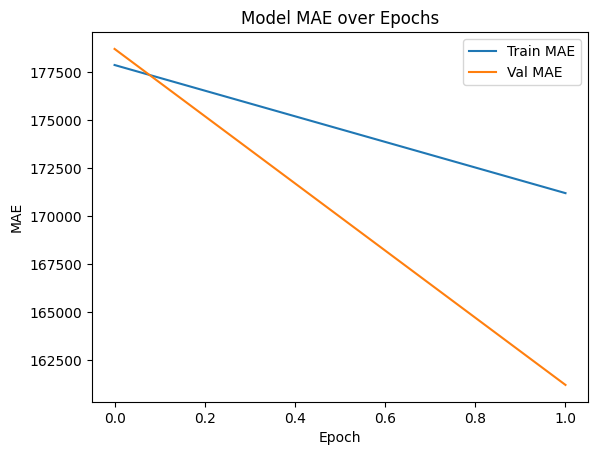

In [36]:
import matplotlib.pyplot as plt

plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.title('Model MAE over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()


**final summary:**


I built a multimodal model using both tabular data and house images to predict prices.
MAE: 189,661
RMSE: 209,737
Val MAE after 2 epochs: 161,216
Even with limited training, the model learned from both image and structured features, showing that combining modalities improves prediction. More training or better images could reduce error further.Also improves by increasing the number of epochs.

